# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 16/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [1]:
%%capture

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP
import datamapplot
import random




# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from src.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from configs.dreamachine import config



In [2]:
# if want to UPDATE parameters 
# config.transformer_model = "Qwen/Qwen3-Embedding-4B"#"avsolatorio/GIST-small-Embedding-v0"#'BAAI/bge-large-en-v1.5'


### Define parameters for current run


In [3]:
condition = "HS"
sentences = True
random_seed = SEED # uses the global seed 

# Outlier reduction settings
reduce_outliers = True
outlier_strategy = 'probabilities' 
outlier_threshold = 0.1


### Load and preprocess data


In [4]:

# File paths
data_dir = os.path.join(project_root, "DATA", config.name) #config.name is the dataset name
reports_path = os.path.join(data_dir, f"{condition}.csv")
print("Using data from:", reports_path)

results_dir = os.path.join(project_root, "RESULTS")
results_filename = f"GS_results_{condition}_{'sentences' if sentences else ''}.csv"
results_path = os.path.join(results_dir, results_filename)

print("Loading results from:", results_path)

# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path,sep='\t')['reflection_answer']
if sentences:
    df_reports = split_sentences(df_reports)[0]

print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")

Using data from: /Users/rb666/Projects/MOSAIC/DATA/dreamachine/HS.csv
Loading results from: /Users/rb666/Projects/MOSAIC/RESULTS/GS_results_HS_sentences.csv

Successfully loaded and processed 682 sentences.


### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [5]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

embedding_model = SentenceTransformer(config.transformer_model)
print("Using embedding model:", config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=0.005#config.min_df
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: all-mpnet-base-v2


Batches: 100%|██████████| 22/22 [00:02<00:00, 10.00it/s]

Embeddings and vectorizer ready.


### Train BERTopic model 

In [6]:
#  Load best params from grid search
results_GS = pd.read_csv(results_path)
chosen_params = results_GS.iloc[0]
print("Best parameters loaded from grid search:")
print(chosen_params)

# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=int(chosen_params['top_n_words']),
    nr_topics=None, #"auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step

Best parameters loaded from grid search:
n_components             15.000
n_neighbors              20.000
min_dist                  0.025
min_cluster_size         10.000
min_samples               5.000
top_n_words              10.000
coherence_score           0.560
cohenrece_score_umass     0.000
n_topics                 14.000
Name: 0, dtype: float64


### Initial analysis (before LLM)

In [7]:
# Calculate initial coherence score
initial_coherence, _ = calculate_coherence(topic_model, df_reports)
print(f"\nInitial Coherence Score (C_v): {initial_coherence}")
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")



Number of valid topics used for coherence calculation (excludes outliers -1): 11

Initial Coherence Score (C_v): 0.347325466262427
Initial number of topics extracted: 12
Initial number of outlier sentences: 244


In [8]:
# reduce outliers (optional)
if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence, _ = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")


Reducing outliers using the 'probabilities' strategy with threshold 0.1...
Remaining outliers after reduction: 76
Number of valid topics used for coherence calculation (excludes outliers -1): 11
Coherence Score after outlier reduction: 0.5203806340424513


In [9]:
topic_model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [10]:
topic_model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

# Update model with LLAMA 3 for Topic Labelling

In [11]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)


Setting up Llama3 for topic representation...


llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [12]:


prompt = """Q:
Topic documents:
[DOCUMENTS]

Topic keywords: '[KEYWORDS]'

Find the most appropriate scientific label for this topic based on the above information. The label should:

1. Uses Title Case with proper spacing
2. Avoids abstract interpretations
3. Reflects directly reported phenomena
4. Be concise yet comprehensive (2-5 words max)

Only return the label itself, without any additional text or punctuation.
A:
"""

pipeline_kwargs = {
    "max_tokens": 10, 
    "temperature": 0.3,    # conservative to minimise randomness and hallucinations
    "top_p": 0.7, # Range: 0 to 1. Focus on most probable tokens from the input
    "repeat_penalty": 2 # >1.0: penalise repeated words, useful for avoiding redundant terms in labels
}

representation_model = {"LLM": LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)}


# UPDATE THE FITTED MODEL WITH THE NEW REPRESENTATION MODEL (not re-training)
print("Updating topic representations with Llama 3...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")


Updating topic representations with Llama 3...


100%|██████████| 12/12 [00:16<00:00,  1.38s/it]

Update complete.


### Process and apply topic labels generated by Llama3


In [13]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
#llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Outlier" for topic in topics] #create mapping for all sentences
len(all_labels) #should be the same as the sentences

#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print("\nGenerated Topic Labels:")
topic_labels



Generated Topic Labels:


{0: 'Color Perception',
 1: 'Cosmic Consciousness Experience',
 2: 'Positive Emotional Experience',
 3: 'Visual Perception Phenomenon',
 4: 'Spiritual Experience',
 5: 'Personal Experience Report',
 6: 'Auditory-Visual Synesthesia',
 7: 'Stream of Consciousness Experience',
 8: 'Psychedelic Experience Report',
 9: 'Human Development',
 10: 'Visual Perception Experience'}

### Visualisation

Calculating medoids: 100%|██████████| 12/12 [00:02<00:00,  5.79it/s]


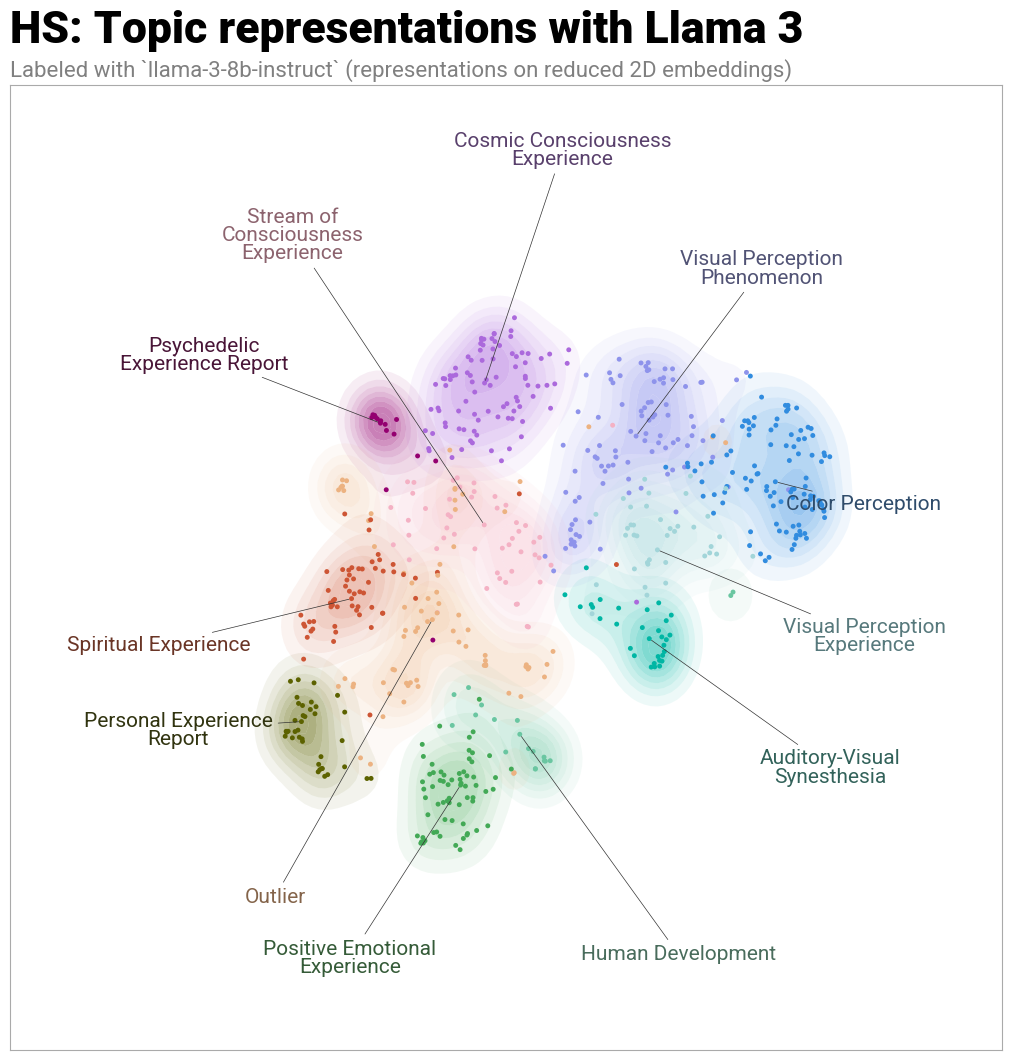

In [14]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition}: Topic representations with Llama 3",
   sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
)

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

### create and save final topic summary

In [15]:
def create_topic_summary(topic_labels, df_reports, topics):
    """Creates df summarizing topic counts and content."""
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # map the topic number to the generated Llama label
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Topic_Content', 'count'),
            Content=('Topic_Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate and display the summary ---
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

print("\nFinal Topic Summary:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save summary to CSV ---
summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
topic_summary.to_csv(summary_results_file, index=False)
print(f"\nSummary saved to {summary_results_file}")



Final Topic Summary:
                           Topic_Label  Topic_Number  Sentence_Count
0                     Color Perception             0             102
1         Visual Perception Phenomenon             3              93
2      Cosmic Consciousness Experience             1              91
3                              Outlier            -1              76
4        Positive Emotional Experience             2              66
5                 Spiritual Experience             4              60
6   Stream of Consciousness Experience             7              51
7         Visual Perception Experience            10              39
8           Personal Experience Report             5              38
9          Auditory-Visual Synesthesia             6              31
10                   Human Development             9              19
11       Psychedelic Experience Report             8              16

Summary saved to /Users/rb666/Projects/MOSAIC/RESULTS/topic_analysis_HS.csv
